# Markov Chain Monte Carlo Example

## Problem Statement

You have been hired by the U.S. Nuclear Regulatory Commission (http://www.nrc.gov) to investigate 
the number of failures in 10 power plant pumps. The pumps were in operation at diﬀerent plants, 
so they can be considered to be independent. The table below shows the numbers of failures $y_i$ 
and the length of operation time $t_i$, for i = 1, . . . , 10 (in 1000s of hours). A pump is considered 
to be out of compliance if there is more than 1 failure per 1000 hours of use.


| Pump  | $t_i$  | $y_i$ |
|:-----:|:------:|:---:|
| 1     | 94.5   | 5   |
| 2     | 15.7   | 1   |
| 3     | 62.9   | 5   |
| 4     | 126.0  | 14  |
| 5     | 5.2    | 3   |
| 6     | 31.4   | 19  |
| 7     | 1.05   | 1   |
| 8     | 1.05   | 1   |
| 9     | 2.1    | 4   |
| 10    | 10.5   | 22  |


In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist
%matplotlib inline

t = np.array([94.5, 15.7, 62.9, 126.0, 5.2, 31.4, 1.05, 1.05, 2.1, 10.5]) # Length of operation per pump
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22]) # number of failures per pump

## Modeling the Problem

Pump failures are event occurences in time intervals, so we're going to model the number of pump failures as a poisson distribution:

$$p(y_i|\theta_i) = \frac{e^{-\theta_i t_i} (\theta_i t_i)^{y_i}}{y!}$$

where $t_i$ is the length of pump i's operation time (in thousands of hours) and $y_i$ is the number of failers of pump i.

We're going to put a prior distribution on the mean $\theta$ in the form a gamma distribution:

$$p(\theta_i|\alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \theta_i^{\alpha - 1} e^{-\theta_i \beta}$$

where $\alpha$ = 1

As well as a Gamma prior on  the rate $\beta$:

$$p(\beta|c, d) = \frac{d^c}{\Gamma(c)} \beta^{c - 1} e^{-\beta d}$$

where c = d = 1 (Yes, we're *only* putting a prior on $\beta$, and not $\alpha$ (yet)).

So our joint posterior distribution is:

$$p(\mathbf{\theta}, \beta | \mathbf{y}) = \big[\prod_{i=1}^k p(y_i|\theta_i) p(\theta_i|\alpha, \beta)\big] p(\beta)$$

This isn't any distribution I know, which means we'll need to use Markov Chain Monte Carlo to approximate it.  Since it's a multivariate distribution, I'll want to use Gibbs sampling.

## Deriving Posterior Densities

First for our poisson means, $\mathbf{\theta}$:

$$p(\theta_i | \theta_{-i}, \beta, \mathbf{y}) \propto p(y_i | \theta_i) p(\theta_i | \alpha, \beta) $$
$$\propto e^{-\theta_i t_i} (\theta_i t_i)^{y_i} \theta_i^{\alpha- 1} e^{-\theta \beta}$$
$$\propto e^{-\theta_i (t_i + \beta)} (\theta_i t_i)^{y_i + \alpha - 1}$$

This looks like a gamma distribution kernel, specifically $Gamma(y_i +\alpha, t_i + \beta)$

Now for our gamma rate $\beta$:

 $$p(\beta | \theta, \mathbf{y}) \propto \big[\prod_{i=1}^k p(\theta_i|\beta)\big]p(\beta) $$
 $$\propto \big[\prod_{i=1}^k \beta^{\alpha} e^{\theta_i \beta}\big] \beta^{c - 1} e^{-d \beta}$$
 $$\propto \beta^{k \alpha + c - 1} e^{-\beta([\sum_{i=1}^k \theta_i] + d)}$$
 $$\beta | \theta, \mathbf{y} \sim Gamma(k\alpha + c, [\sum_{i=1}^k \theta_i] + d)$$
 
 ## Gibbs Sampling
 
 We have closed form posteriors for $\mathbf{\theta}$ and $\beta$ (we derived that they both have gamma kernels, and since they are pdf's, we know what the normalizing constant needs to be), so we can sample values directly from these. And since our poisson means $\theta_i$'s are independent of each other, we can sample them together as a vector. 

In [62]:
# initialize variables
theta = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
k = y.size
a = np.array([1])
b = np.array([1])
c = 1
d = 1

for i in range(20000):
    # sample from p(theta | b, y)
    theta = np.vstack((theta, np.random.gamma((y + a), scale=(1 / (t + b[-1])), size=k)))
    # sample from p(b | theta, y)
    b = np.append(b, np.random.gamma((k + c), scale=(1.0 / (np.sum(theta[-1]) + d))))

thetas = theta
betas = b

## MCMC Results
### Summary Statistics

In [46]:
# calculate stats for thetas
means = np.mean(thetas, axis=0)
medians = np.median(thetas, axis=0)
stds = np.std(thetas, axis=0)
# stats for beta
means = np.append(means, np.mean(betas))
medians = np.append(medians, np.median(betas))
stds = np.append(stds, np.std(betas))

# use Pandas dataframe to make results display pretty
results = pd.DataFrame(np.column_stack((means, medians, stds)), 
                       index=["theta{0}".format(i) for i in range(1, 11)] + ["beta"], 
                        columns=['mean', 'median', 'standard deviation'])
print("***** Summary Statistics *****")
results

***** Summary Statistics *****


,mean,median,standard deviation
theta1,0.062333,0.058840,0.026270
theta2,0.117662,0.097961,0.084778
theta3,0.093008,0.087767,0.038367
theta4,0.117539,0.114818,0.031052
theta5,0.600924,0.549776,0.304994
theta6,0.606225,0.595819,0.134816
theta7,0.811309,0.666477,0.603994
theta8,0.822126,0.680031,0.611432
theta9,1.413940,1.307569,0.664438
theta10,1.918452,1.888476,0.411470


### Posterior PDF plots

''

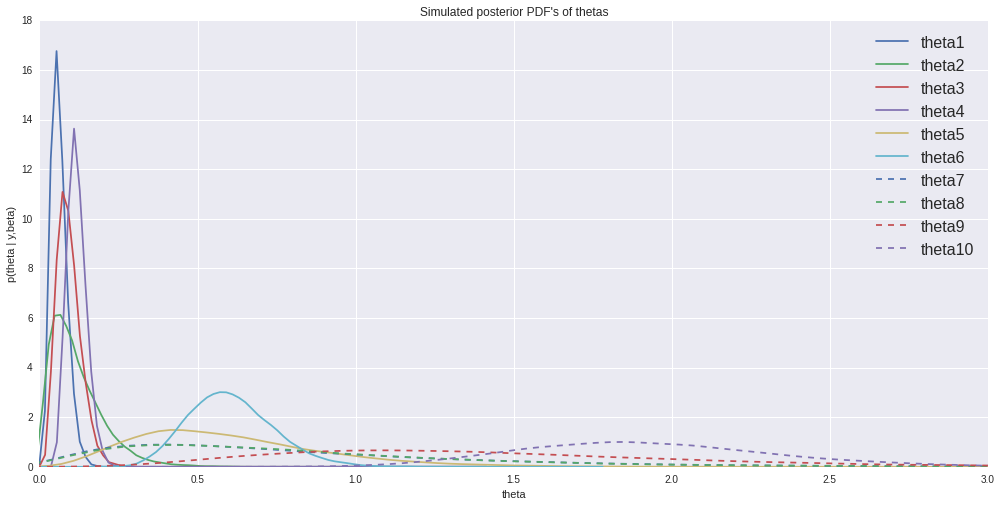

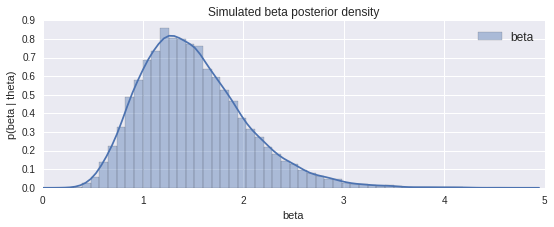

In [47]:
# Plot thetas
plt.figure(figsize=(17, 8))
for i in range(10):
    if (i > 5):
        marker = '--'
    else:
        marker = '-'
    sns.kdeplot(thetas[:,i], linestyle=marker, label="theta{0}".format(i+1));
    
plt.legend(fontsize=16)
plt.title("Simulated posterior PDF's of thetas")
plt.xlim((0,3))
plt.ylabel("p(theta | y,beta)")
plt.xlabel("theta")

# Plot beta pdf
plt.figure(figsize=(9, 3))
sns.distplot(betas, label="beta")
plt.legend(fontsize=12)
plt.title("Simulated beta posterior density")
plt.xlim((0,5))
plt.ylabel("p(beta | theta)")
plt.xlabel("beta")
""

### String Dectet

Vivaldi might say that ten violins is too much treble to go through for unaesthetic plot like this, but young "data scientists" in the bay tell me they're hip.

''

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


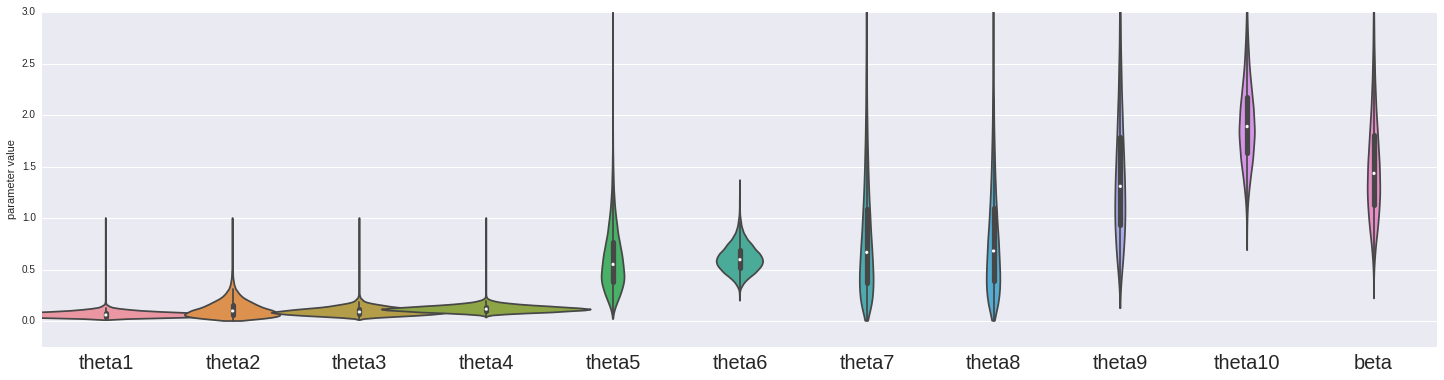

In [48]:
plt.figure(figsize=(25, 6))
df = pd.DataFrame(data=np.append(thetas, np.expand_dims(betas,1), axis=1), 
                  columns=["theta{0}".format(i) for i in range(1, 11)] + ["beta"])
sns.violinplot(data=df, cut=0, width=2)
plt.ylim((-.25,3))
plt.xticks(fontsize=20)
plt.ylabel("parameter value")
""

## MCMC Convergence

### Sample Paths

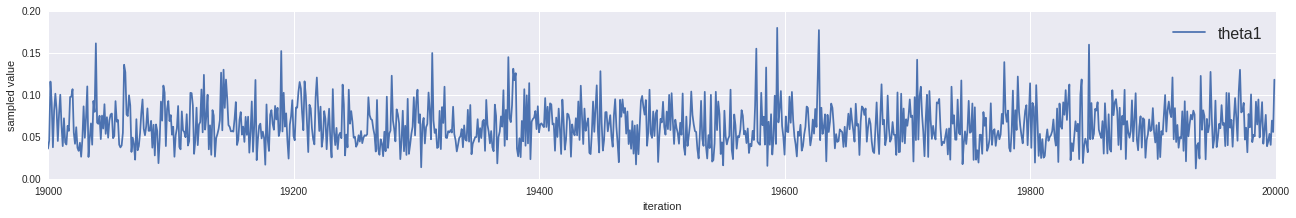

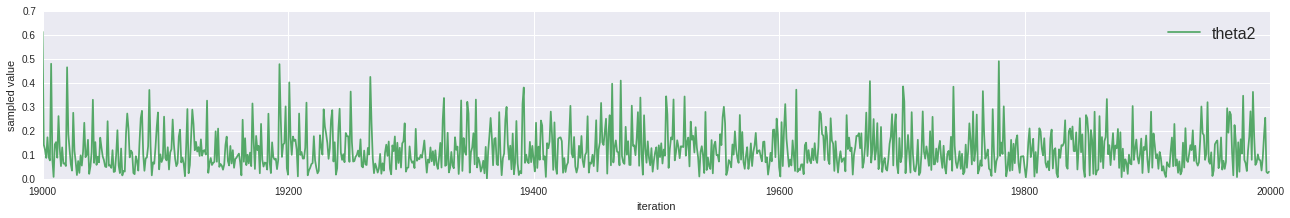

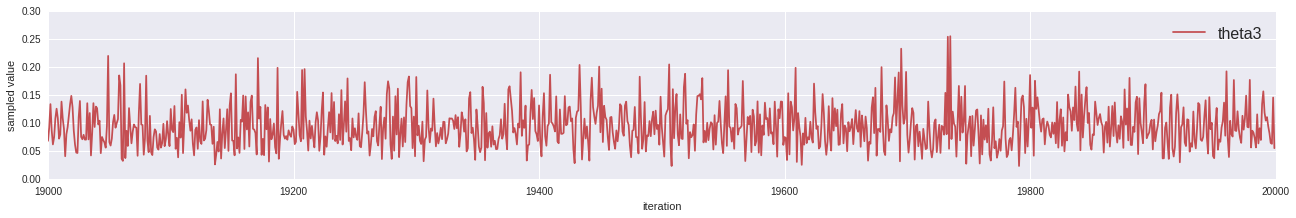

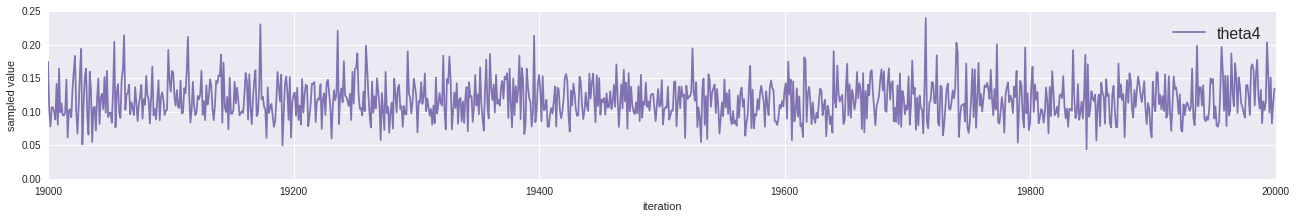

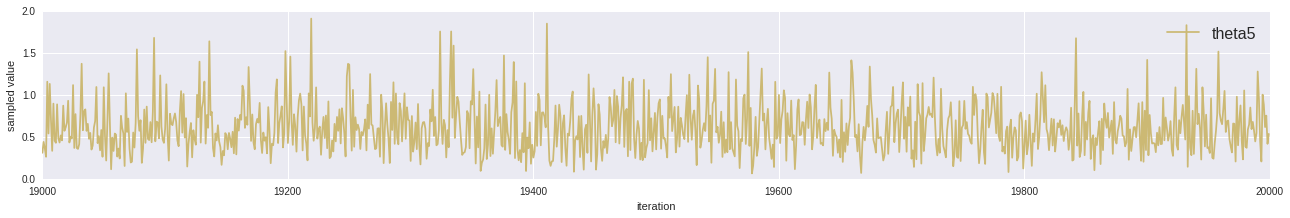

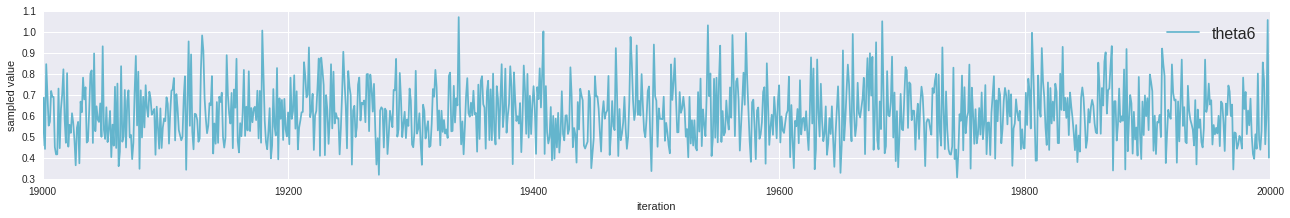

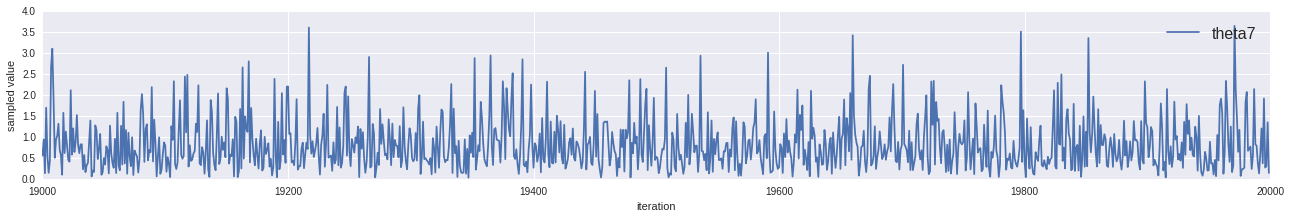

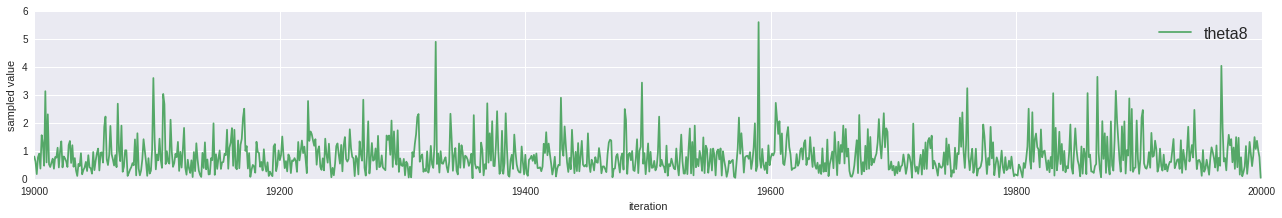

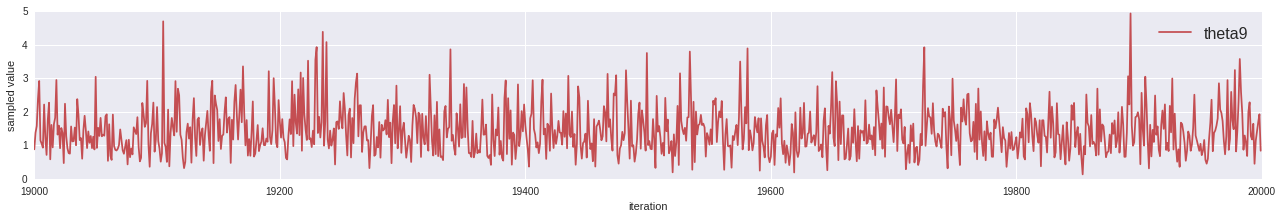

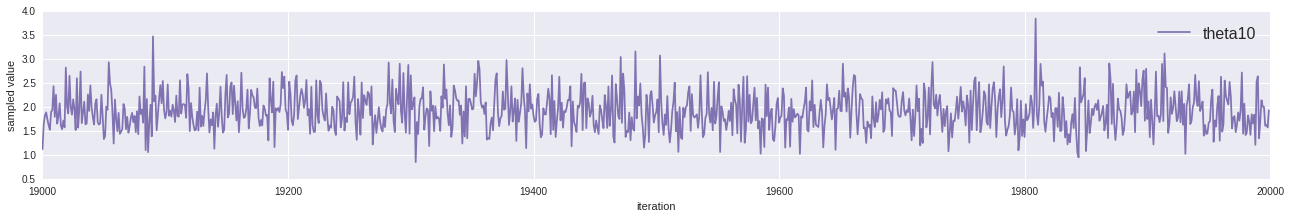

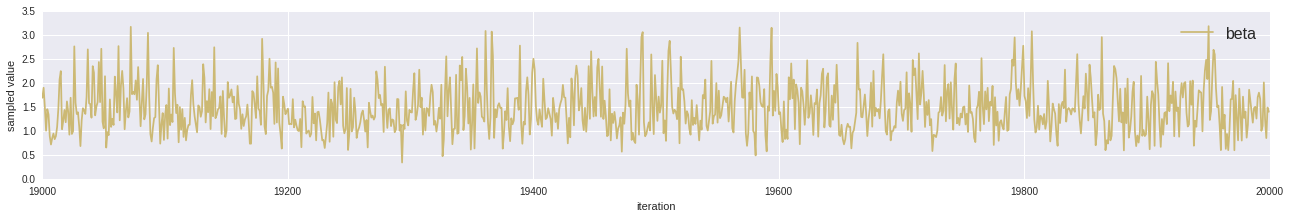

In [63]:
x = np.arange(19000, 20000)

for i in range(11):
    plt.figure(figsize=(22, 3))
    if (i == 10):
        plt.plot(x, betas[19001:],  label="beta", c=sns.color_palette()[i % 6])
    else:
        plt.plot(x, thetas[19001:,i],  label="theta{0}".format(i+1), c=sns.color_palette()[i % 6])
    plt.legend(fontsize=16)
    plt.xlabel("iteration")
    plt.ylabel("sampled value")
        

Those sample paths look beautilfly wiggly

## Autocorrelation Plots

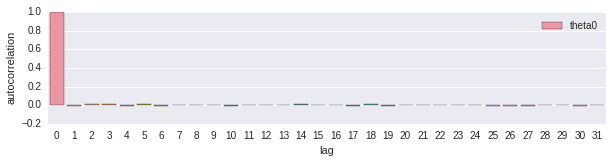

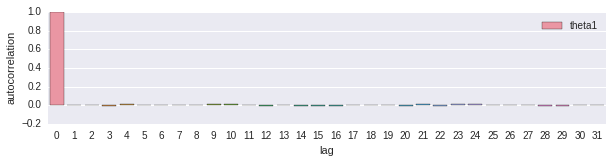

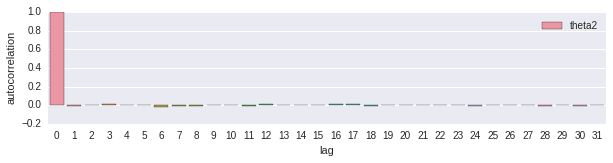

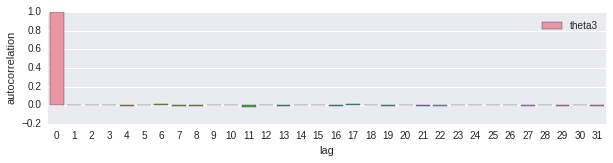

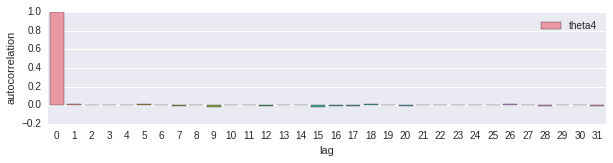

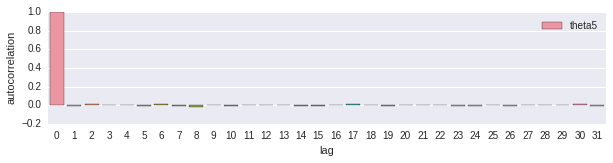

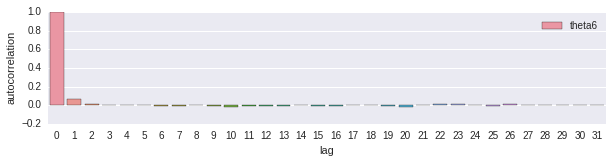

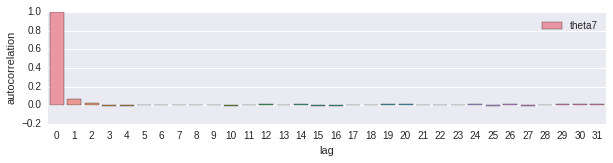

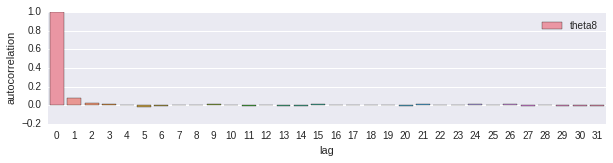

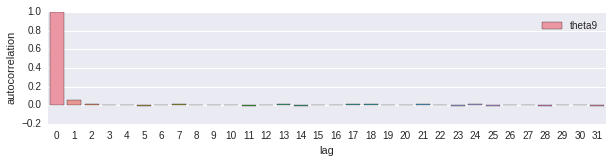

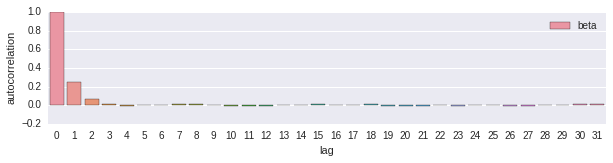

In [50]:
x = np.arange(32)

for i in range(11):
    plt.figure(figsize=(10, 2))
    if (i == 10):
        sns.barplot(x, pd.Series([pd.Series(betas).autocorr(i) for i in range(0,32)]), label="beta")
    else:
        sns.barplot(x, pd.Series([pd.Series(thetas[:,i]).autocorr(lag) for lag in range(0,32)]),
                    label="theta{0}".format(i))
    plt.legend(fontsize=10)
    plt.ylabel("autocorrelation")
    plt.xlabel("lag")

Almost no autocorrelation, which is great.

## Part 2 - adding a prior on $\alpha$

We are now going to let $\alpha$ be exponentially distributed with mean $\mu = 1$.

So since we now need to sample values for alpha, we need to figure out its posterior:

$$p(\alpha | \mathbf{\theta, \beta}) \propto \big[\prod_{i=1}^k p(\theta_i|\alpha, \beta)\big]p(\alpha) $$
$$ \propto \big[\prod_{i=1}^k \frac{\beta^{\alpha} \theta_i^{\alpha - 1}}{\Gamma(\alpha)}\big] e^{-\mu \alpha} $$
$$ \propto \big(\frac{\beta^{\alpha}}{\Gamma(\alpha)}\big)^k \big[\prod_{i=1}^k \theta_i^{\alpha - 1}\big] e^{-\mu \alpha} $$

Well, I don't know what that thing is or how to sample from it, so we have to do a Metropolis-Hastings step to sample $\alpha$

## Gibbs sampling with MH step

I'm going to use a Gamma(1,1) proposal distribution to generate candidates for $\alpha$

In [51]:
# Initialize variables
theta = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
k = y.size
a = np.array([1])
b = np.array([1])
c = 1
d = 1
mu= 1

# Posterior kernel for alpha.  Returns value proportional to p(alpha | theta, beta)
def apost(a, theta, b):
    return np.power(np.power(b,a) / gammafunc(a), k) * np.prod(np.power(theta, a - 1)) * np.exp(-1*mu*a)

# Gibbs Sampling
for i in range(20000):
    theta = np.vstack((theta, np.random.gamma((y + a[-1]), scale =(1 / (t + b[-1])), size=k)))
    
    #Metropolis-Hastings step for alpha
    a_cand = np.random.gamma(1) # Sample alpha candidate from proposal distribution
    # Metropolis-Hastings ratio:   f(a*)g(a_t) / f(a_t)g(a*)
    r = (apost(a_cand, theta[-1], b[-1]) * gammadist.pdf(a[-1], 1)) / \
    (apost(a[-1], theta[-1], b[-1]) * gammadist.pdf(a_cand, 1))
    
    if (np.random.rand() > np.amin((r, 1))):
        a = np.append(a, a[-1])       
    else:
        a = np.append(a, a_cand)
    
    b = np.append(b, np.random.gamma((k + c), scale=(1.0 / (np.sum(theta[-1]) + d))))

thetas = theta
alphas = a
betas = b

## Summary Statistics

In [52]:
# calculate stats for thetas
means = np.mean(thetas, axis=0)
medians = np.median(thetas, axis=0)
stds = np.std(thetas, axis=0)
# stats for beta
means = np.append(means, np.mean(betas))
medians = np.append(medians, np.median(betas))
stds = np.append(stds, np.std(betas))
# stats for alpha
means = np.append(means, np.mean(alphas))
medians = np.append(medians, np.median(alphas))
stds = np.append(stds, np.std(alphas))

# use Pandas dataframe to make results display pretty
results = pd.DataFrame(np.column_stack((means, medians, stds)), 
                       index=["theta{0}".format(i) for i in range(1, 11)] + ["beta", "alpha"], 
                        columns=['mean', 'median', 'standard deviation'])
print("***** Summary Statistics *****")
results

***** Summary Statistics *****


,mean,median,standard deviation
theta1,0.061488,0.057793,0.026381
theta2,0.109919,0.090550,0.082408
theta3,0.091280,0.085781,0.038720
theta4,0.116866,0.114540,0.030984
theta5,0.578453,0.526386,0.301488
theta6,0.604398,0.592415,0.137564
theta7,0.750847,0.601204,0.590269
theta8,0.762356,0.613814,0.593654
theta9,1.355073,1.248310,0.654670
theta10,1.904843,1.872507,0.413575


## Posterior Density Plots

''

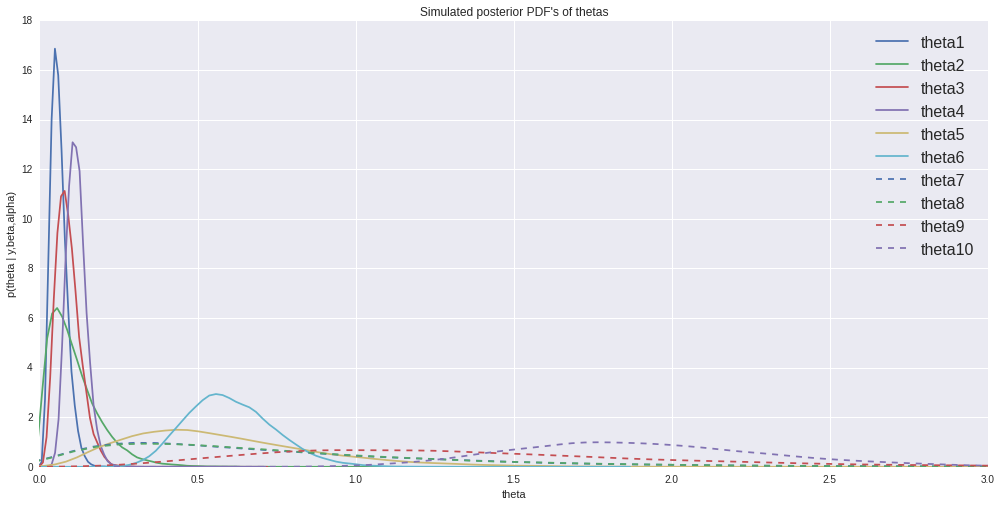

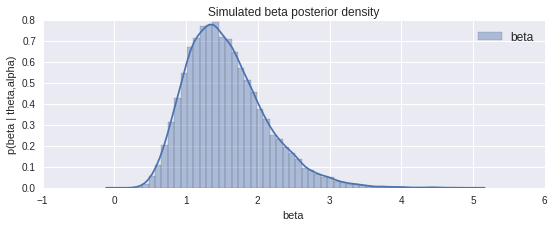

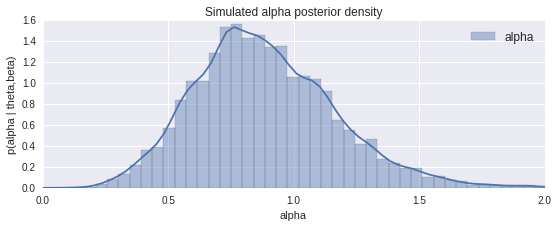

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


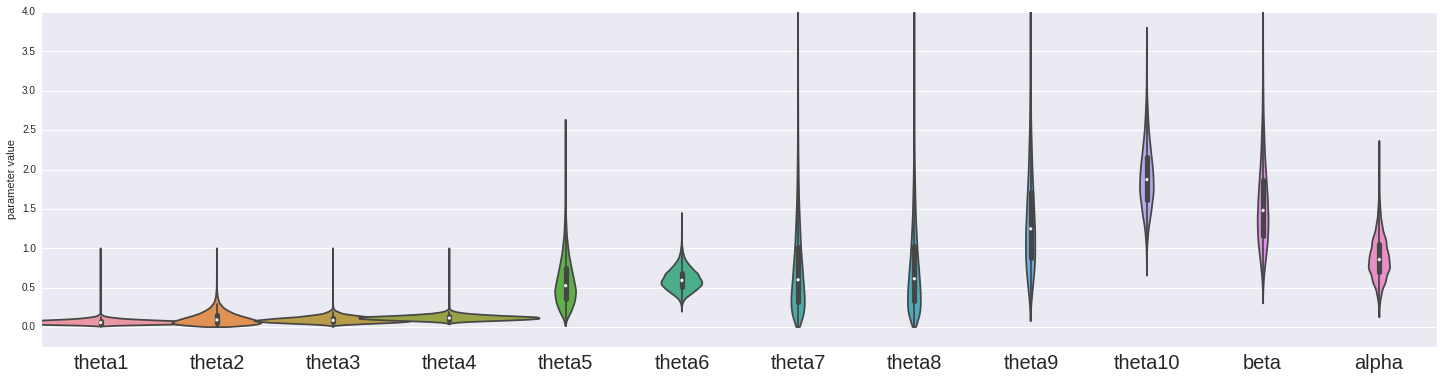

In [53]:
# Plot thetas
plt.figure(figsize=(17, 8))
for i in range(10):
    if (i > 5):
        marker = '--'
    else:
        marker = '-'
    sns.kdeplot(thetas[1000:,i], linestyle=marker, label="theta{0}".format(i+1));
    
plt.legend(fontsize=16)
plt.title("Simulated posterior PDF's of thetas")
plt.xlim((0,3))
plt.ylabel("p(theta | y,beta,alpha)")
plt.xlabel("theta")

# Plot beta pdf
plt.figure(figsize=(9, 3))
sns.distplot(betas, label="beta")
plt.legend(fontsize=12)
plt.title("Simulated beta posterior density")
#plt.xlim((0,5))
plt.ylabel("p(beta | theta,alpha)")
plt.xlabel("beta")

# Plot alpha pdf
plt.figure(figsize=(9, 3))
sns.distplot(alphas, label="alpha")
plt.legend(fontsize=12)
plt.title("Simulated alpha posterior density")
plt.xlim((0,2))
plt.ylabel("p(alpha | theta,beta)")
plt.xlabel("alpha")

plt.figure(figsize=(25, 6))
df = pd.DataFrame(data=np.append(thetas, np.column_stack((betas, alphas)), axis=1),
                  columns=["theta{0}".format(i) for i in range(1, 11)] + ["beta", "alpha"])
sns.violinplot(data=df, cut=0, width=2)
plt.ylim((-.25,4))
plt.xticks(fontsize=20)
plt.ylabel("parameter value")
""
""

## Sample Paths

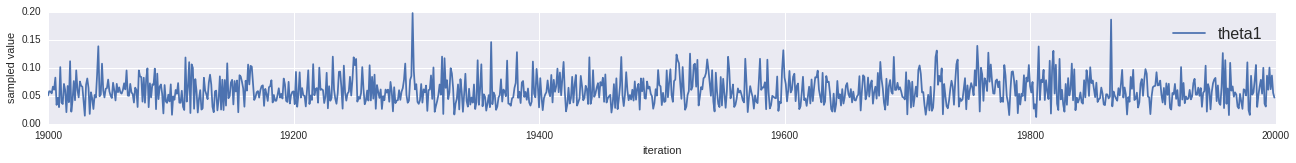

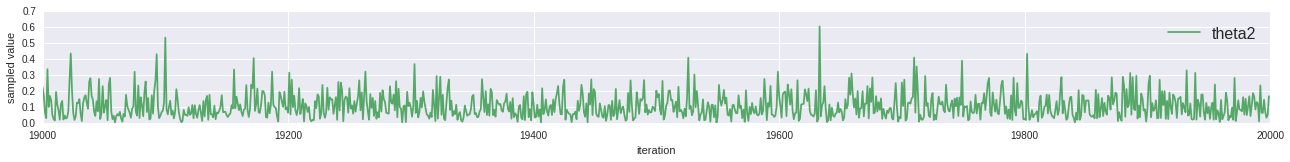

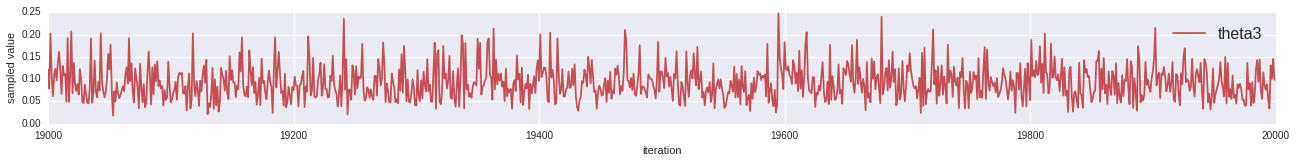

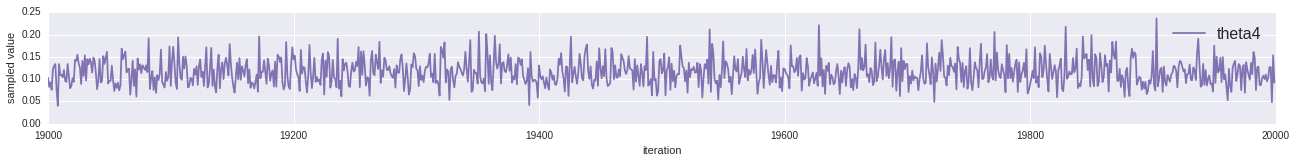

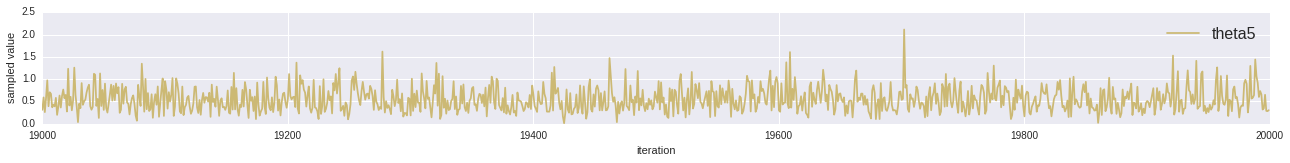

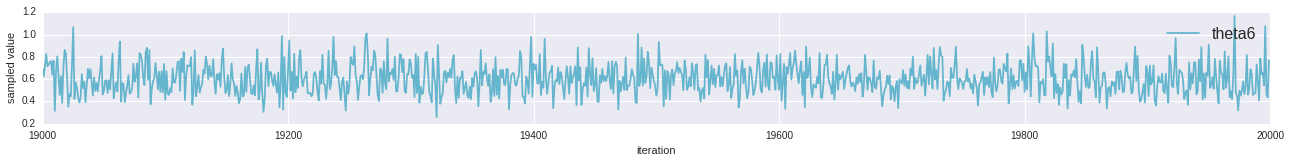

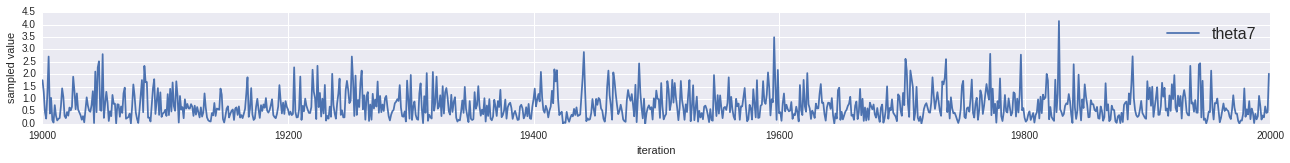

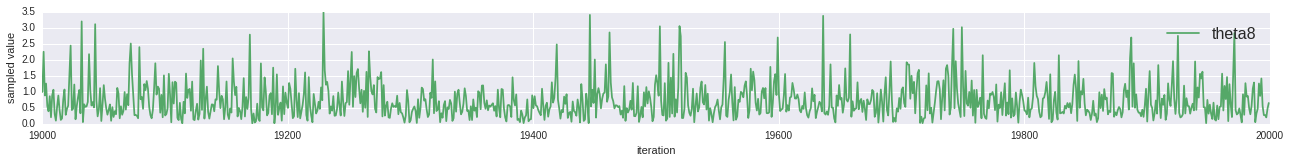

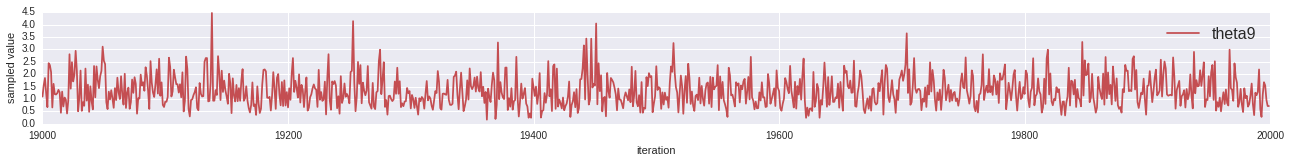

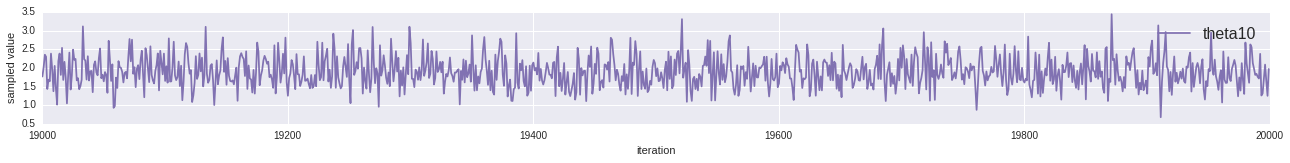

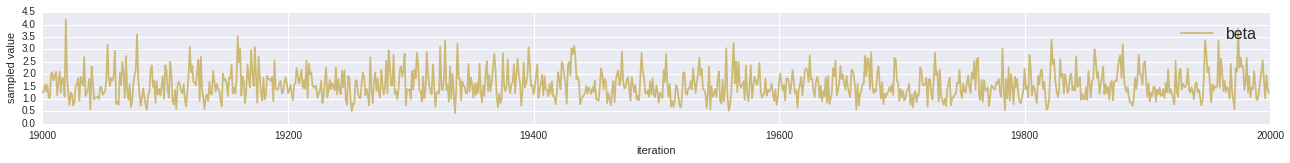

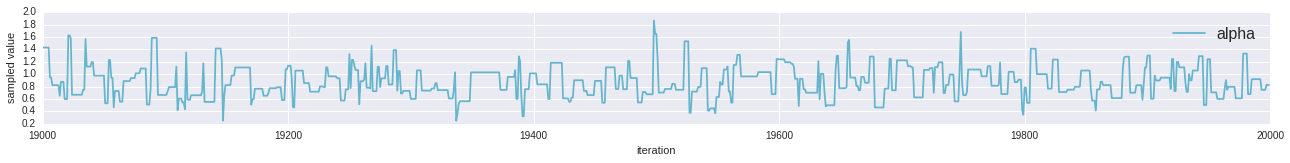

In [54]:
x = np.arange(19000, 20000)

for i in range(12):
    plt.figure(figsize=(22, 2))
    if (i == 10):
        plt.plot(x, betas[19001:],  label="beta", c=sns.color_palette()[i % 6])
    elif (i == 11):
        plt.plot(x, alphas[19001:],  label="alpha", c=sns.color_palette()[i % 6])
    else:
        plt.plot(x, thetas[19001:,i],  label="theta{0}".format(i+1), c=sns.color_palette()[i % 6])
    plt.legend(fontsize=16)
    plt.xlabel("iteration")
    plt.ylabel("sampled value")

## ACF Plots

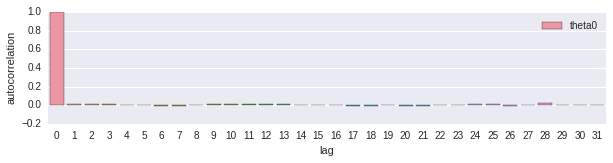

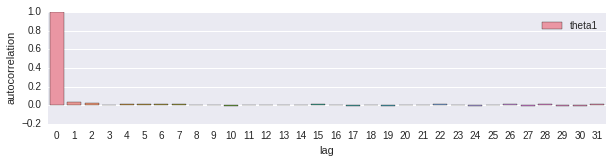

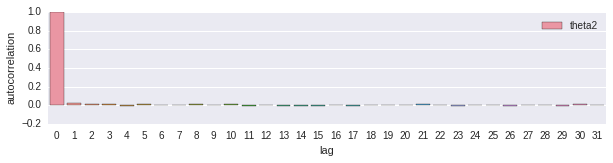

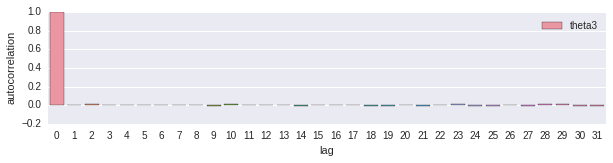

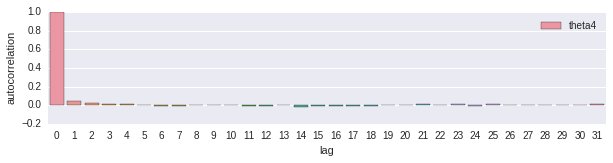

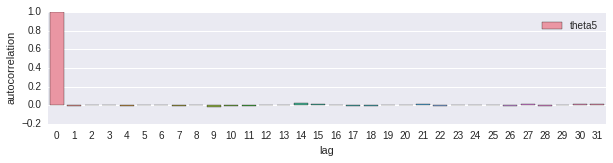

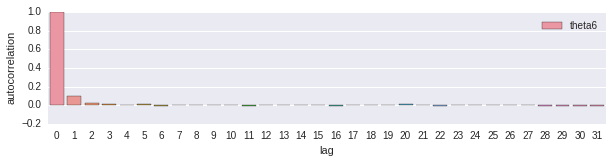

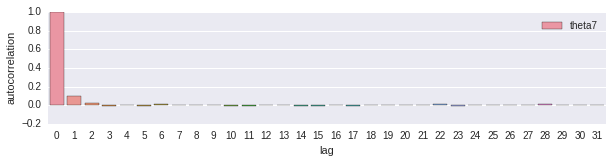

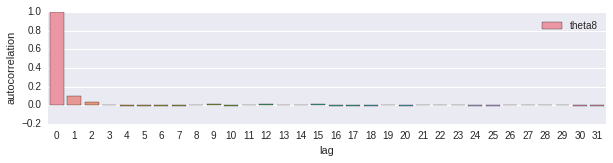

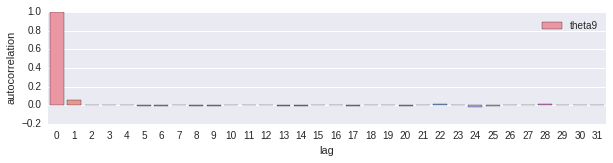

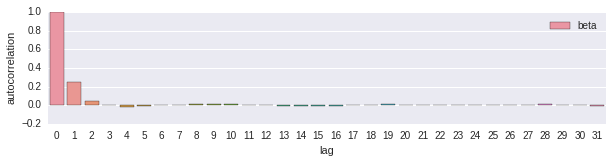

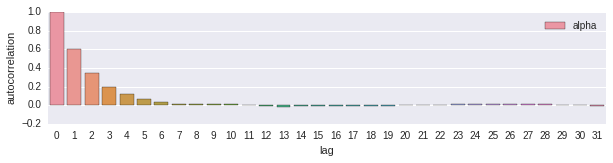

In [55]:
x = np.arange(32)

for i in range(12):
    plt.figure(figsize=(10, 2))
    if (i == 10):
        sns.barplot(x, pd.Series([pd.Series(betas).autocorr(i) for i in range(0,32)]), label="beta")
    elif (i == 11):
        sns.barplot(x, pd.Series([pd.Series(alphas).autocorr(i) for i in range(0,32)]), label="alpha")
    else:
        sns.barplot(x, pd.Series([pd.Series(thetas[:,i]).autocorr(lag) for lag in range(0,32)]),
                    label="theta{0}".format(i))
    plt.legend(fontsize=10)
    plt.ylabel("autocorrelation")
    plt.xlabel("lag")

## Is there a significant difference in the failure rate of the pumps?

Yes, we can tell that there is a significant difference in the failure rate of the pumps just by looking at our posterior density plots (although we can make this guess just by looking at the original data as well).  For example:

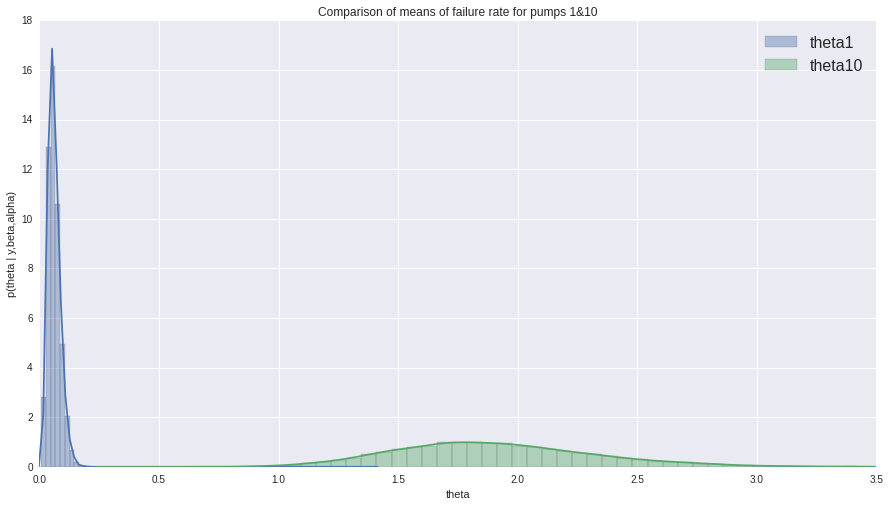

In [56]:
# Plot thetas
plt.figure(figsize=(15, 8))

sns.distplot(thetas[:,0], label="theta1")
sns.distplot(thetas[:,9], label="theta10")

plt.legend(fontsize=16)
plt.title("Comparison of means of failure rate for pumps 1&10")
plt.xlim((0,3.5))
plt.ylabel("p(theta | y,beta,alpha)")
plt.xlabel("theta")

The posterior densities for these two pumps barely overlap at all.  Pump 1 has a mean of $\approx 0.06$ and a standard deviation of $\approx 0.026$, while pump 10 has a mean of $\approx 1.9$ and a standard deviation of $\approx 0.4$.  So we are very confidant that these pumps have different failure rates.